In [1]:
from keras import losses, metrics
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Activation, Input
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, concatenate, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats, interp
import os, sys, pickle, shutil
import pandas as pd
import numpy as np
import random, datetime, time
from sklearn.model_selection import KFold


# tensorflow 사용 시 seed 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
SEED = 98

# GPU setting

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

print(datetime.datetime.now())

2023-01-26 02:48:28.529633


# 1. Loading input

In [2]:
import pandas as pd
import numpy as np

SRATE = 300
LEN_INPUT = 120
STRIDE = 0
LEN_NRS = 120
    
ECG_FILT = '3rd-bandpass'
PPG_FILT = 'lowess'
CORR_THRES = 0.9 # cutoff
THRES = 4 # THRES for NRS classification

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
hyper_path = f'PACU_SRATE{SRATE}_LEN{LEN_INPUT}_LEN_NRS{LEN_NRS}_STR{STRIDE}_PPG-{PPG_FILT}_ECG-{ECG_FILT}'
input_path = f"../DL_model/dataset/{hyper_path}/"
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
c_train = np.load(input_path+'c_train.npz')['arr_0']
c_test = np.load(input_path+'c_test.npz')['arr_0']

Y_train = y_train > THRES
Y_test = y_test > THRES

gender_train = np.load(input_path+'gender_train.npz', allow_pickle=True)['arr_0']
gender_test = np.load(input_path+'gender_test.npz', allow_pickle=True)['arr_0']

age_train = np.load(input_path+'age_train.npz', allow_pickle=True)['arr_0']
age_test = np.load(input_path+'age_test.npz', allow_pickle=True)['arr_0']

print('done', flush=True)

print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print(f'average of moderate-to-severe pain(NRS>4): train {np.mean(Y_train):.3f}, test {np.mean(Y_test):.3f} \n')


print(datetime.datetime.now())

loading train...done
x_train shape: (1995, 36000, 2)
x_test.shape: (220, 36000, 2)
average of moderate-to-severe pain(NRS>4): train 0.586, test 0.555 

2023-01-26 02:48:21.668611


### Input validation

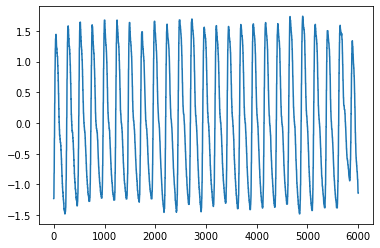

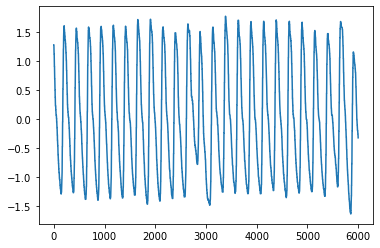

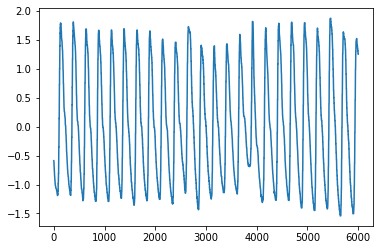

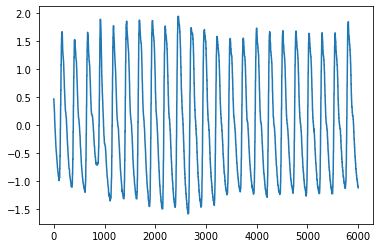

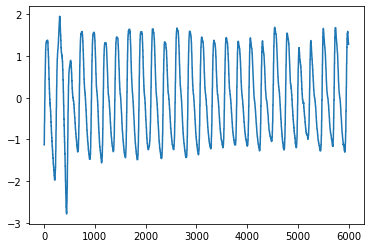

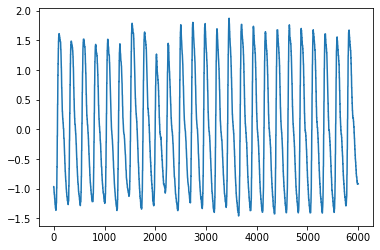

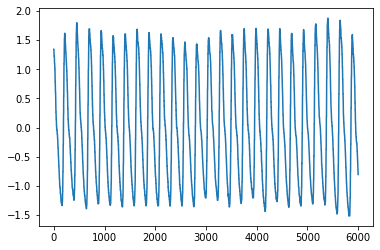

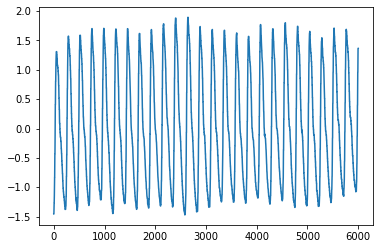

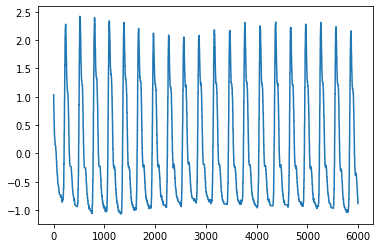

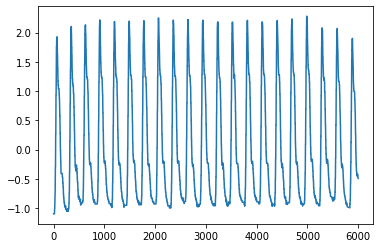

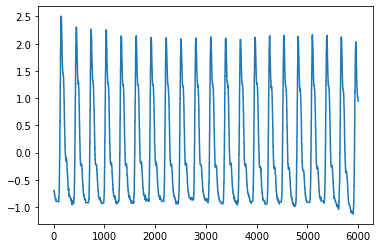

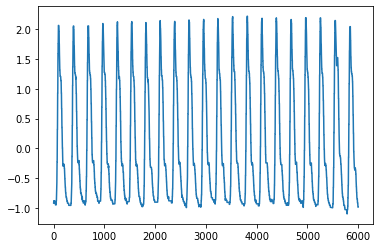

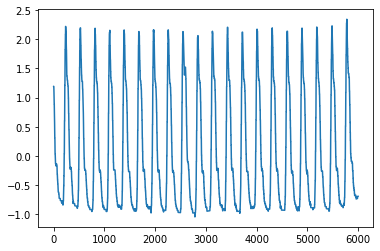

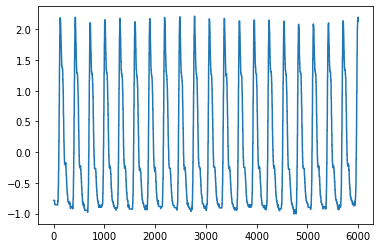

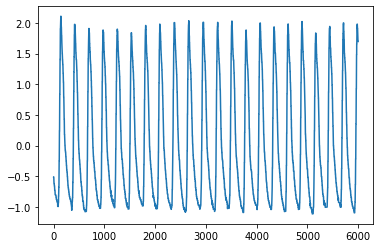

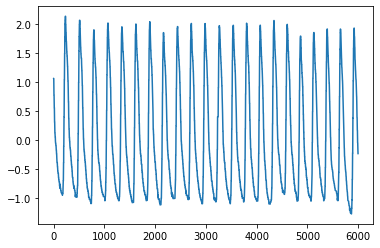

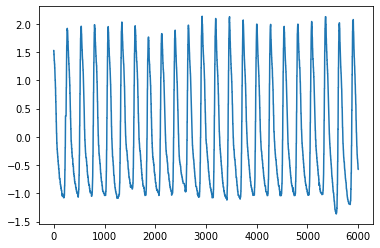

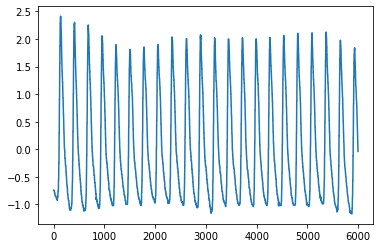

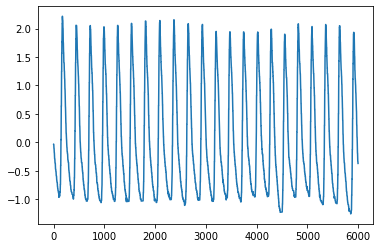

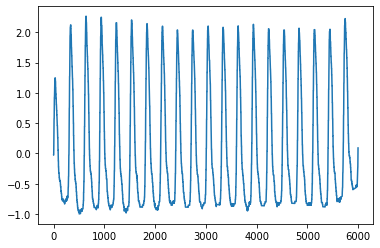

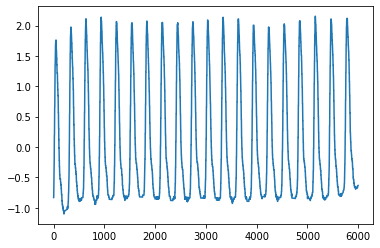

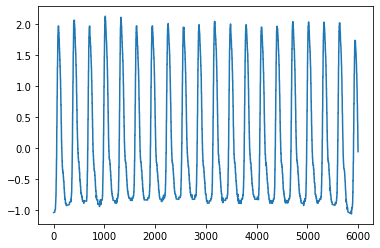

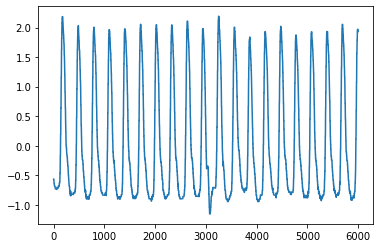

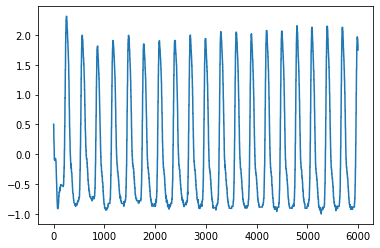

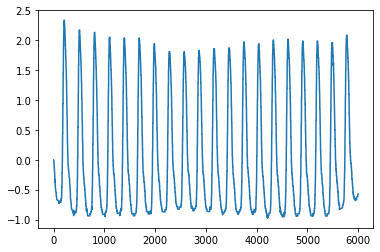

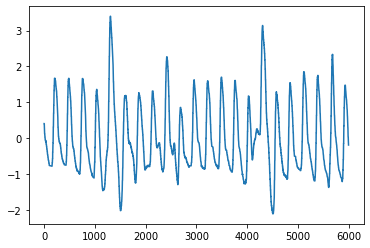

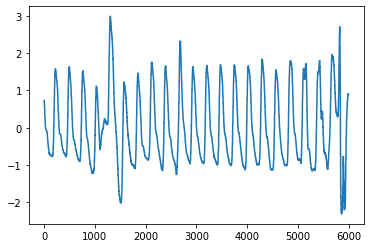

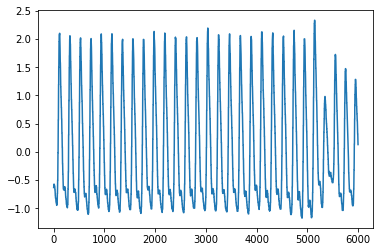

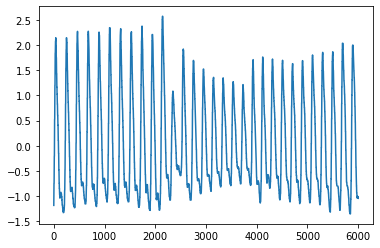

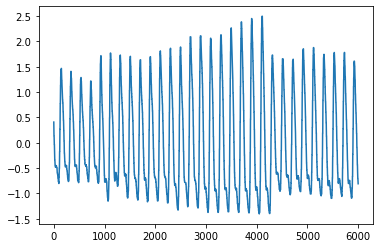

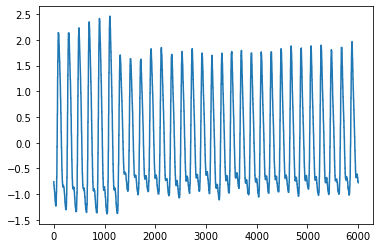

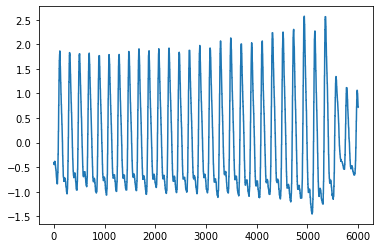

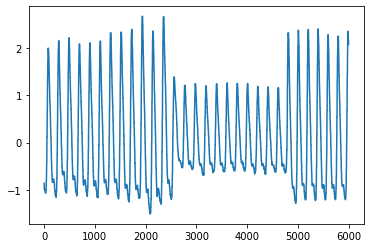

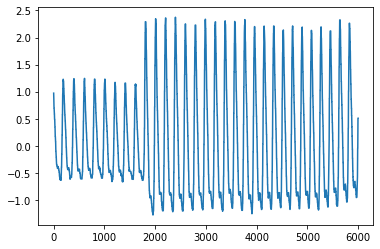

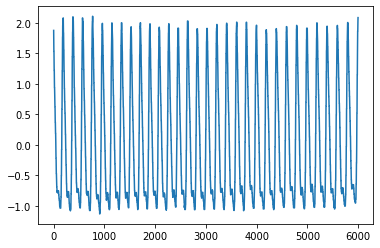

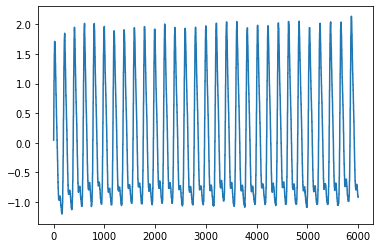

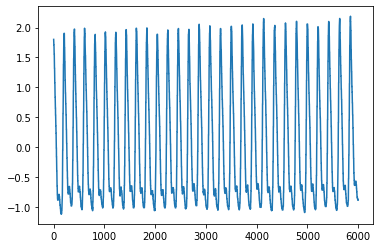

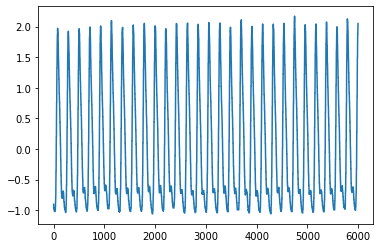

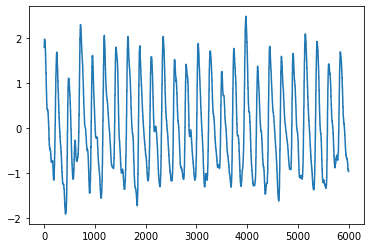

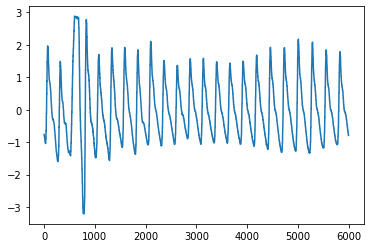

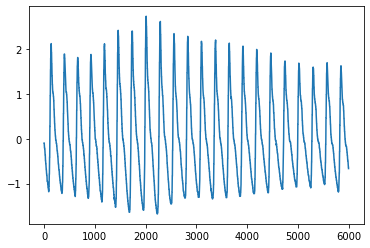

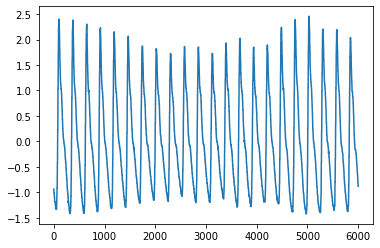

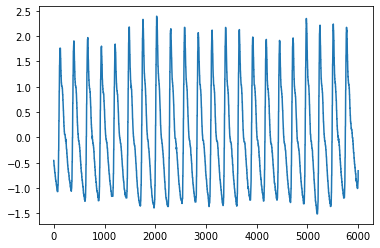

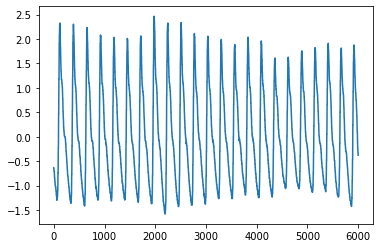

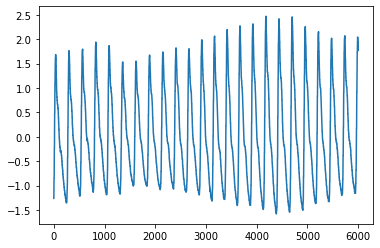

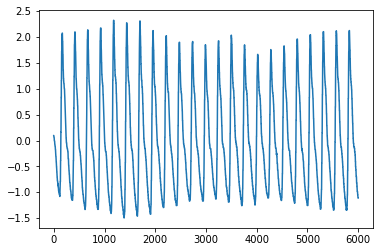

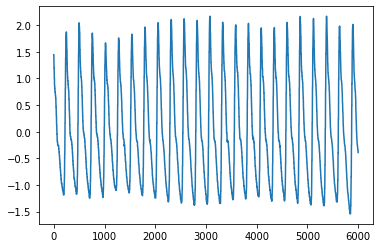

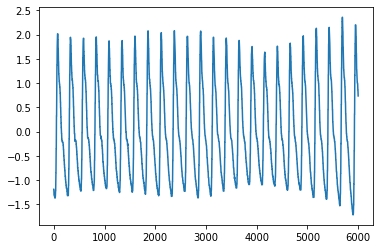

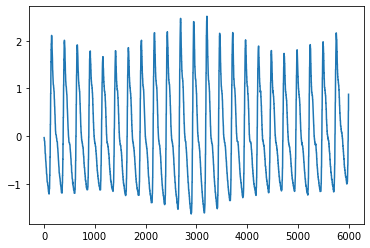

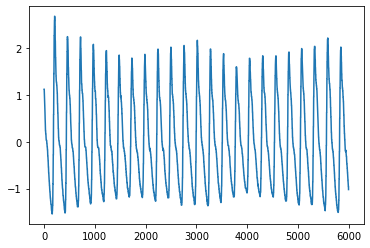

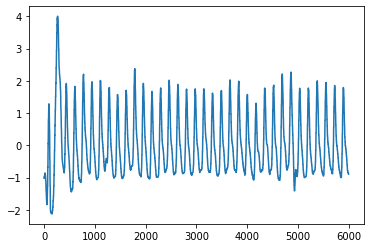

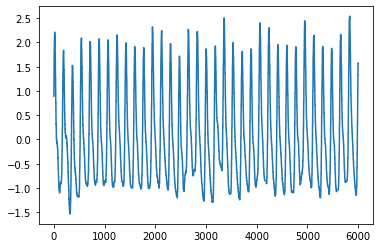

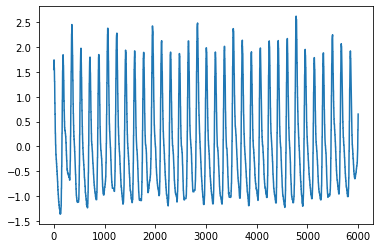

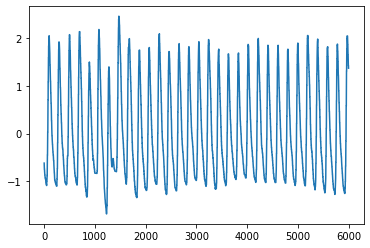

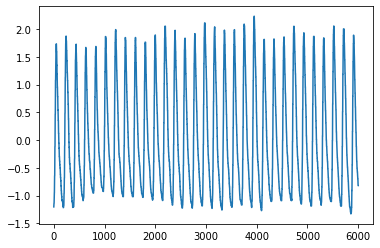

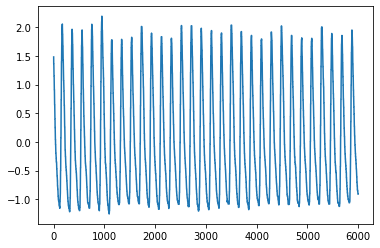

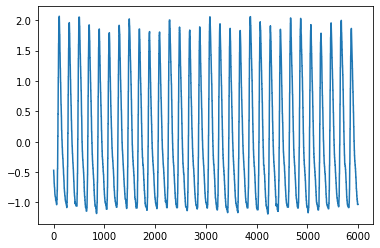

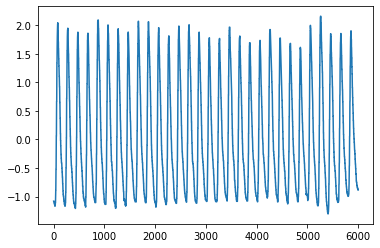

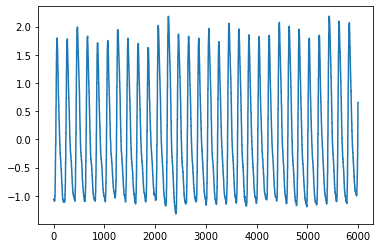

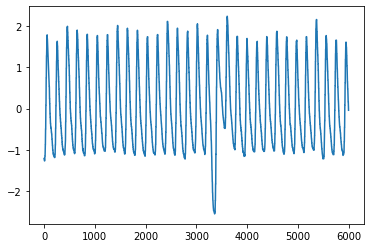

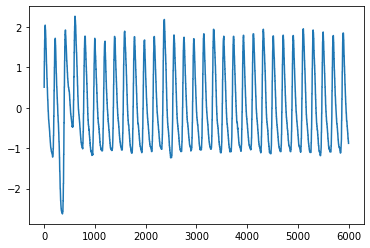

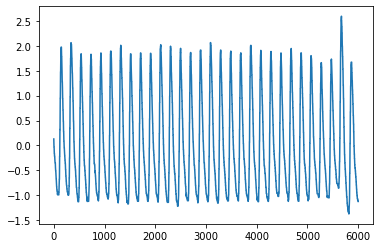

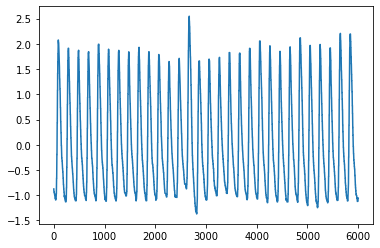

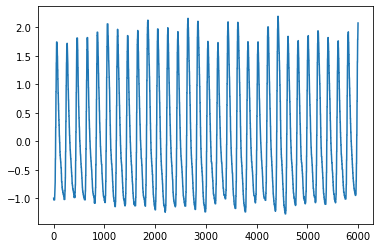

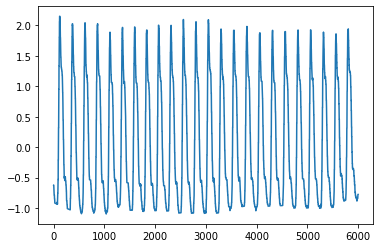

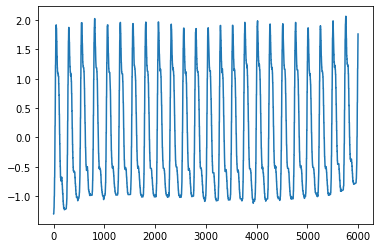

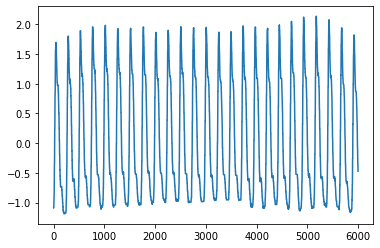

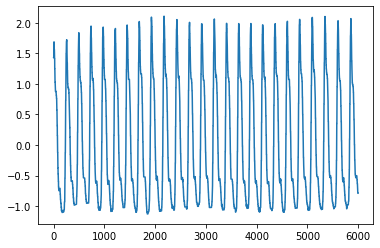

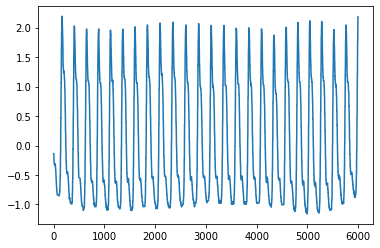

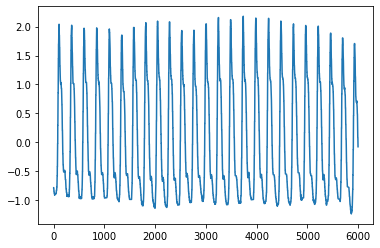

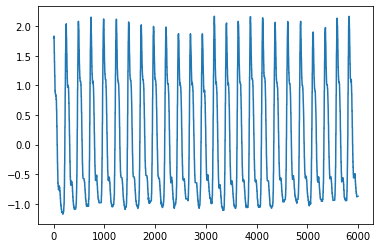

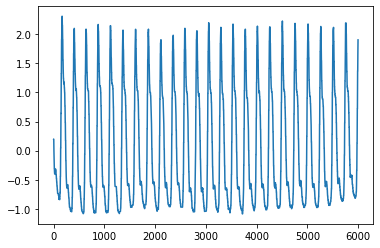

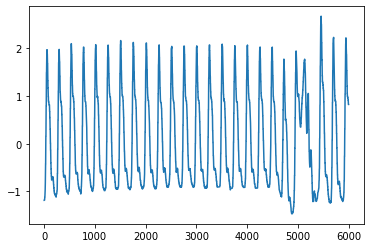

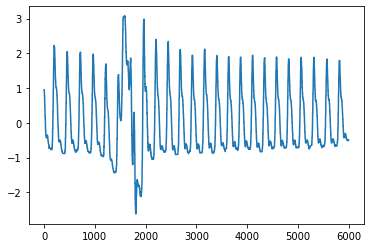

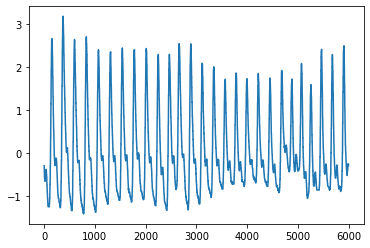

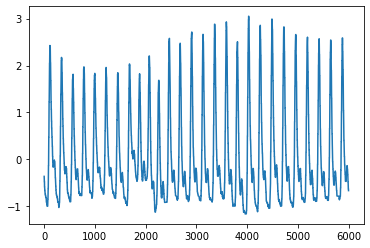

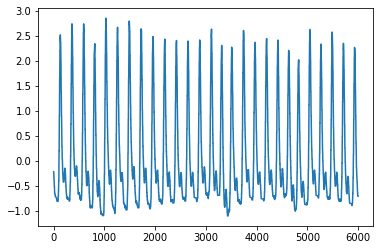

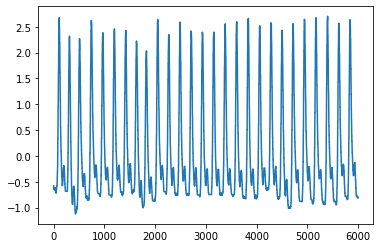

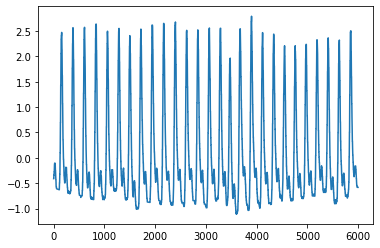

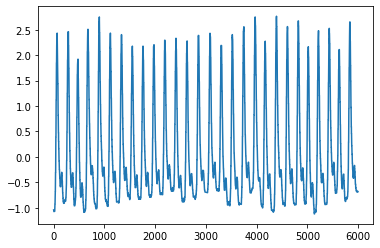

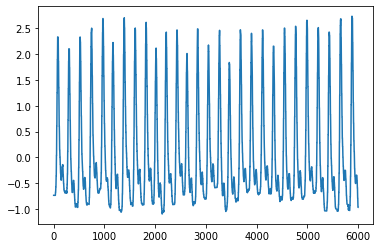

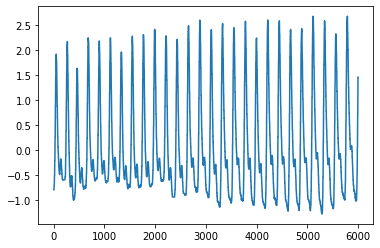

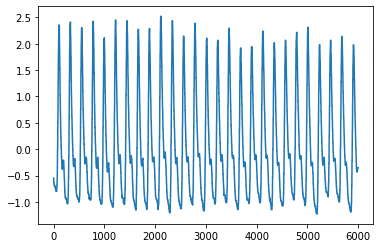

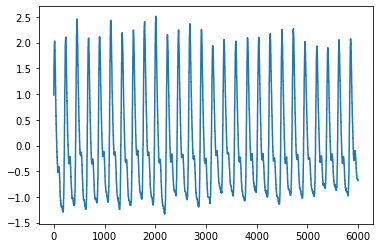

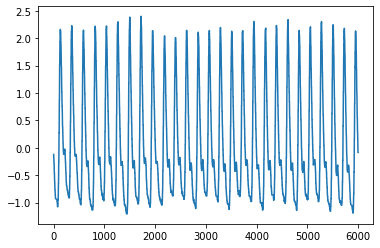

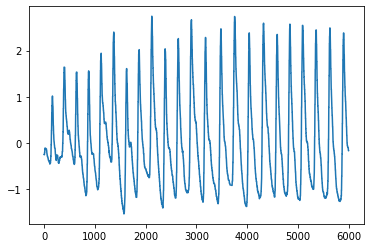

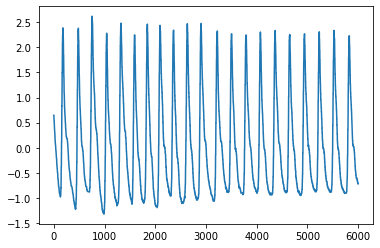

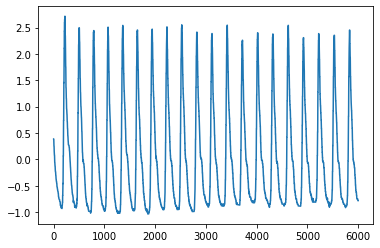

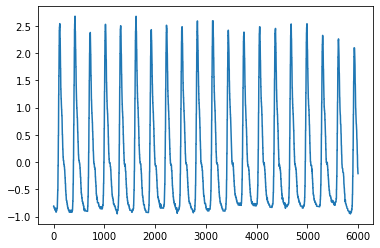

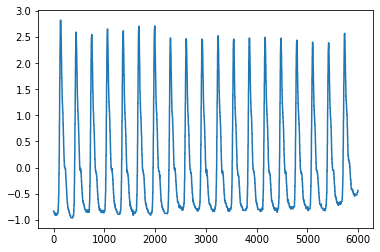

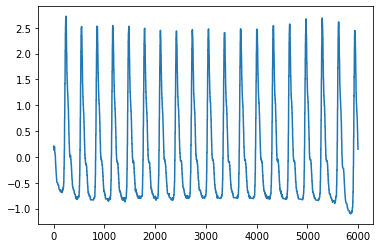

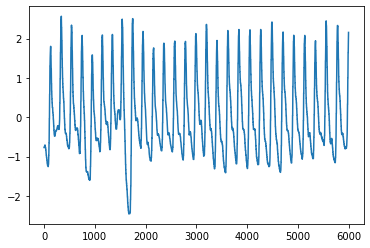

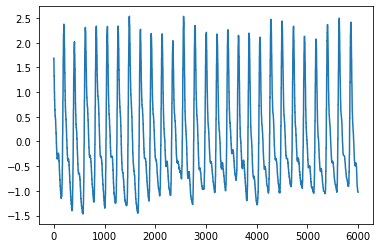

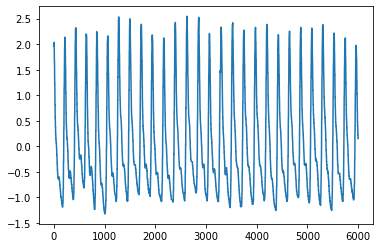

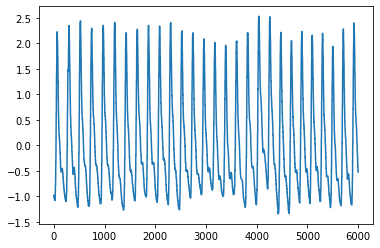

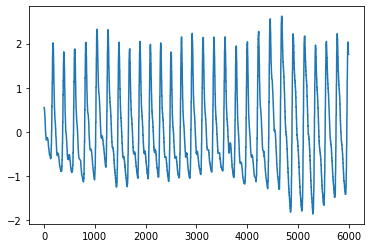

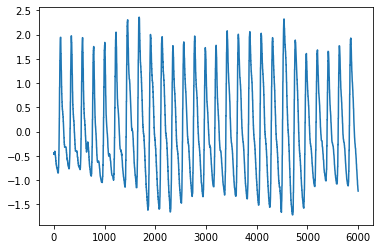

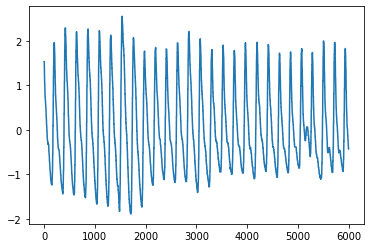

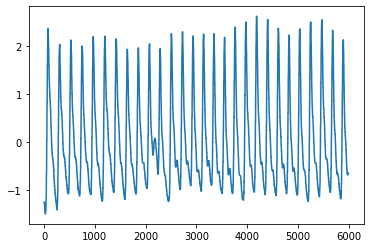

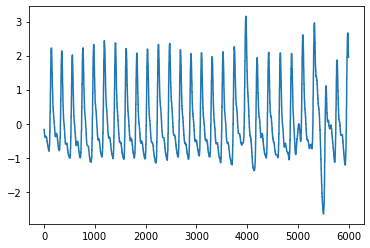

In [4]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(20,10))

num = 100
for i in range(num,num+100):
    plt.plot(x_train[i,:,0])
    plt.show()

## Input, output settings

## Sample weights

In [5]:
w_samp_train = np.ones(shape=(len(y_train),))
print(datetime.datetime.now())

2023-01-26 02:50:11.211363
ERROR! Session/line number was not unique in database. History logging moved to new session 308


# 2. Setting

In [4]:
# folder
nfold = 4  # 각각의 hyperparameter에 대해 k-fold 를 시행하고 평균을 구한다.
ntest = 500
rootdir = f"randomSearch/PACU/CNN_NRS{LEN_NRS}_LEN{LEN_INPUT}_STRIDE{STRIDE}_NRS>4_4layers_Bin_{nfold}fold_test{ntest}"

if not os.path.exists(rootdir):
    os.mkdir(rootdir)

# 모델에 대한 정보 txt로 저장
f = open(f'{rootdir}/README.txt', 'w')
f.write(f'model: 1D CNN 4 layers, binary classification')
f.write(f'input: ECG,PPG of NRS report time 120s, output: NRS>4')
f.close()
    

# test_settings
layer_settings, test_settings = [], []


# hyperparamters
globalpool_opts = ['max','ave']

# hyperparamters pool
filt_opts = [16, 32, 64, 128] # num of filters(kernel)
stride_opts = [1,2,3]  # other opts: stride = (kernel-1)/2
kernel_opts = range(3,11,2) # kernel size
pool_size = 2
dropout_opts  = [0, 0.1, 0.2, 0.3, 0.4, 0.5] # dropout rate
dense_opts = [0, 8, 16, 32, 64]
BATCH_SIZE = [32, 64, 128, 256, 512]
lr_opts = [0.001, 0.002, 0.0005]

print('start making test settings...', end='', flush=True)
# test settings
nfilt, kernels, strides = [], [], []
for i in range(5):
    nfilt.append(0)
    kernels.append(0)
    strides.append(0)

for nfilter in filt_opts:
    for kernel in kernel_opts:
        for stride in stride_opts:
        #layer_settings.append([nfilter, kernel, int((kernel-1)/2)])       
            layer_settings.append([nfilter, kernel, stride])
    
for dense_node in dense_opts:
    for dropout_cnn in dropout_opts:
        for dropout_fc in dropout_opts:
            for batch_size in BATCH_SIZE:
                for learning_rate in lr_opts:
                    test_settings.append([dense_node, dropout_cnn, dropout_fc, batch_size, learning_rate])                                   

                        
print('done')
print(datetime.datetime.now())

start making test settings...done
2023-01-26 02:49:25.880902


# 3. Random Search

## Classification model

In [ ]:
from keras import metrics

seed_everything(SEED)

# random search for hyperparameter
ntrial = ntest
train_errs, val_errs = [] ,[]
test_acc, test_roc, test_prc = [], [], []
#test_rmse, test_mae, test_auc = [], [], []
random_settings = []


for itrial in range(ntrial):
    # grid search
    # test_setting = test_settings[itrial]

    # random search
    print('random search {}/{}'.format(itrial, ntrial))
    
    # total conv layers of the model
    n_conv = random.choice([2,3,4]) 
    # test settings
    for i in range(n_conv):
        nfilt[i], kernels[i], strides[i] = random.choice(layer_settings)
    dense_node, dropout_cnn, dropout_fc, batch_size, learning_rate = random.choice(test_settings)
    

    # 이번 옵션에 대한 결과 디렉토리
    odir_f = f'batch{batch_size},'
    for i in range(n_conv):
        odir_f += f'layer{i+1}:c{nfilt[i]}filt{kernels[i]}str{strides[i]},'
    odir_f += f'1conv,dropout{dropout_cnn},dnodes{dense_node},dropout{dropout_fc}'#,lr{learning_rate}'
    random_settings.append(odir_f)
    
    odir = rootdir + '/' + odir_f
    if not os.path.exists(odir):
        os.mkdir(odir)

        
    # model validation (VGG)
    out_shape = x_train.shape[1]
    for i in range(n_conv):
        out_shape = out_shape / pool_size / strides[i]
    if out_shape < 1:
        os.rmdir(odir)
        continue
        

    # build a model
    inp = Input(shape=(x_train.shape[1],x_train.shape[2]))
    out = inp

    
    # VGC block
    for i in range(n_conv):
        out = Conv1D(filters=nfilt[i], kernel_size=kernels[i], strides=strides[i], padding='same', activation='relu')(out)
        out = BatchNormalization()(out)
        out = MaxPooling1D(pool_size)(out)
    

    # globalpooling vs flattening vs 1x1 convolution
    #elif globalpool_opt == 'ave':
    #    out = GlobalAveragePooling1D()(out)
    out = Conv1D(filters=1, kernel_size=1)(out)
    out = Flatten() (out)


    if dense_node != 0:
        out = Dropout(dropout_cnn)(out)
        out = Dense(dense_node, activation='relu')(out)
    out = Dropout(dropout_fc)(out)
    out = Dense(1, activation='sigmoid')(out)


    model = Model(inputs=[inp], outputs=[out])
    model.save_weights(f'{odir}/initial_weights.hdf5')
        

    # 4-fold cv
    kfold = KFold(nfold)
    tprs, aucs, prs = [], [], []
    pr_aucs, roc_aucs = [], []
    f1_scores, thvals = [], []
    mean_fpr = np.linspace(0,1,100)
    mean_recall = np.linspace(0,1,100)

    switch = 0
    caseids_train = np.unique(c_train)
    for fold, (c_cv_trains_mask, c_cv_test_mask) in enumerate(kfold.split(caseids_train)):
        c_cv_trains = caseids_train[c_cv_trains_mask]
        random.shuffle(c_cv_trains)

        ncv = int(len(c_cv_trains)*0.8)
        c_cv_train = c_cv_trains[:ncv]
        c_cv_val = c_cv_trains[ncv:]

        cv_train_mask = np.isin(c_train, c_cv_train)
        cv_val_mask = np.isin(c_train, c_cv_val)
        cv_test_mask = np.isin(c_train, caseids_train[c_cv_test_mask])


        X_train = x_train[cv_train_mask]
        X_val = x_train[cv_val_mask]
        X_test = x_train[cv_test_mask]  


        # model 학습
        try:
            weightcache = f"{odir}/weights_{fold}.hdf5"
            model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=[tf.keras.metrics.AUC()])
            hist = model.fit(X_train, Y_train[cv_train_mask], sample_weight=w_samp_train[cv_train_mask], validation_data=(X_val, Y_train[cv_val_mask]), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

            model.load_weights(weightcache)
            y_pred = model.predict(X_test).flatten()

            #ROC analysis
            fpr, tpr, t = roc_curve(Y_train[cv_test_mask], y_pred)
            tprs.append(interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            # PR analysis
            prec, recall, th = precision_recall_curve(Y_train[cv_test_mask], y_pred)
            prs.append(interp(mean_recall, prec, recall))
            pr_auc = auc(recall, prec)
            pr_aucs.append(pr_auc)

            print(f' ###{fold} fold : val auc {roc_auc:.3f}, val prc {pr_auc:.3f}###')
            tf.keras.backend.clear_session()
            model.load_weights(f'{odir}/initial_weights.hdf5')

        except Exception as e:
            print(e)
            switch = 1
            shutil.rmtree(odir)
            itrial -= 1
            break

    if switch:
        switch = 0
        continue


    # mean ROC
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_roc = np.std(roc_aucs)
    # mean PRC
    mean_precision = np.mean(prs, axis = 0)
    mean_prc = auc(mean_recall, mean_precision)
    std_prc = np.std(pr_aucs)

    max_idx = roc_aucs.index(max(roc_aucs))
    


    print(f'roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}')
    open(odir+"/model.json", "wt").write(model.to_json())

    os.rename(odir, rootdir+f'/roc{mean_auc:.3f}+-{std_roc:.3f}_prc{mean_prc:.3f}+-{std_prc:.3f}_max{max_idx}__{odir_f}')
    tf.keras.backend.clear_session()


random search 0/500
Epoch 1/100


2023-01-26 02:50:21.822780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-01-26 02:50:22.425492: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


38/38 [==============================] - ETA: 0s - loss: 0.8793 - auc_111: 0.5209
Epoch 00001: val_loss improved from inf to 0.68991, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_0.hdf5
38/38 [==============================] - 7s 98ms/step - loss: 0.8793 - auc_111: 0.5209 - val_loss: 0.6899 - val_auc_111: 0.5267
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.6450 - auc_111: 0.6579
Epoch 00002: val_loss did not improve from 0.68991
38/38 [==============================] - 3s 83ms/step - loss: 0.6433 - auc_111: 0.6610 - val_loss: 0.7008 - val_auc_111: 0.5129
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.5903 - auc_111: 0.7402
Epoch 00003: val_loss did not improve from 0.68991
38/38 [==============================] - 3s 80ms/step - loss: 0.5917 - auc_111: 0.7386 - val_loss: 0.7112 - v

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###0 fold : val auc 0.516, val prc 0.575###
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.8713 - auc: 0.5044
Epoch 00001: val_loss improved from inf to 0.69071, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_1.hdf5
38/38 [==============================] - 5s 96ms/step - loss: 0.8713 - auc: 0.5044 - val_loss: 0.6907 - val_auc: 0.4888
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.6734 - auc: 0.6113
Epoch 00002: val_loss improved from 0.69071 to 0.68869, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_1.hdf5
38/38 [==============================] - 3s 82ms/step - loss: 0.6742 - auc: 0.6099 - val_loss: 0.6887 - val_auc: 0.5194
Epoch

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.464, val prc 0.576###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 0.8974 - auc: 0.4839
Epoch 00001: val_loss improved from inf to 0.70027, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_2.hdf5
38/38 [==============================] - 5s 93ms/step - loss: 0.9004 - auc: 0.4820 - val_loss: 0.7003 - val_auc: 0.4102
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.6898 - auc: 0.5776
Epoch 00002: val_loss improved from 0.70027 to 0.69374, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_2.hdf5
38/38 [==============================] - 3s 82ms/step - loss: 0.6915 - auc: 0.5748 - val_loss: 0.6937 - val_auc: 0.5433
Epoch 3/100
37/38 [============================>.]

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###2 fold : val auc 0.509, val prc 0.620###
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.8817 - auc: 0.4950
Epoch 00001: val_loss improved from inf to 0.69755, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_3.hdf5
38/38 [==============================] - 5s 94ms/step - loss: 0.8817 - auc: 0.4950 - val_loss: 0.6975 - val_auc: 0.4540
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.6715 - auc: 0.6136
Epoch 00002: val_loss improved from 0.69755 to 0.69435, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c128filt3str1,layer2:c16filt3str3,layer3:c32filt9str2,1conv,dropout0.1,dnodes32,dropout0/weights_3.hdf5
38/38 [==============================] - 3s 81ms/step - loss: 0.6709 - auc: 0.6154 - val_loss: 0.6943 - val_auc: 0.4802
Epoch

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.531, val prc 0.570###
roc0.505+-0.025_prc0.601+-0.020
random search 1/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.1753 - auc: 0.4918
Epoch 00001: val_loss improved from inf to 0.68759, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_0.hdf5
3/3 [==============================] - 4s 626ms/step - loss: 1.1753 - auc: 0.4918 - val_loss: 0.6876 - val_auc: 0.5620
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.8716 - auc: 0.5713
Epoch 00002: val_loss improved from 0.68759 to 0.68342, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_0.hdf5
3/3 [==============================] - 1s 264ms/step - loss: 0.8716 - auc: 0.5713 - val_loss: 0.6834 - val_auc: 0.5964
Epoch 3/100
3/3 [==============================] -

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###0 fold : val auc 0.553, val prc 0.640###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0599 - auc: 0.5290
Epoch 00001: val_loss improved from inf to 0.68867, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_1.hdf5
3/3 [==============================] - 3s 578ms/step - loss: 1.0599 - auc: 0.5290 - val_loss: 0.6887 - val_auc: 0.5277
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.8867 - auc: 0.5703
Epoch 00002: val_loss improved from 0.68867 to 0.68735, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_1.hdf5
3/3 [==============================] - 1s 255ms/step - loss: 0.8867 - auc: 0.5703 - val_loss: 0.6874 - val_auc: 0.5179
Epoch

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###1 fold : val auc 0.534, val prc 0.622###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0158 - auc: 0.5292
Epoch 00001: val_loss improved from inf to 0.69483, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_2.hdf5
3/3 [==============================] - 3s 623ms/step - loss: 1.0158 - auc: 0.5292 - val_loss: 0.6948 - val_auc: 0.4918
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.8325 - auc: 0.6094
Epoch 00002: val_loss improved from 0.69483 to 0.69008, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_2.hdf5
3/3 [==============================] - 1s 259ms/step - loss: 0.8325 - auc: 0.6094 - val_loss: 0.6901 - val_auc: 0.5454
Epoch

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###2 fold : val auc 0.558, val prc 0.650###
Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.1936 - auc: 0.5038
Epoch 00001: val_loss improved from inf to 0.68918, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_3.hdf5
3/3 [==============================] - 3s 610ms/step - loss: 1.1936 - auc: 0.5038 - val_loss: 0.6892 - val_auc: 0.4998
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7295 - auc: 0.6264
Epoch 00002: val_loss improved from 0.68918 to 0.68376, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c64filt9str3,layer2:c64filt7str3,layer3:c128filt7str1,1conv,dropout0.1,dnodes16,dropout0.1/weights_3.hdf5
3/3 [==============================] - 1s 328ms/step - loss: 0.7295 - auc: 0.6264 - val_loss: 0.6838 - val_auc: 0.5034
Epoch

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.512, val prc 0.581###
roc0.539+-0.018_prc0.632+-0.026
random search 2/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.2770 - auc: 0.5028
Epoch 00001: val_loss improved from inf to 0.70083, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_0.hdf5
5/5 [==============================] - 4s 372ms/step - loss: 1.2770 - auc: 0.5028 - val_loss: 0.7008 - val_auc: 0.4576
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.9359 - auc: 0.5291
Epoch 00002: val_loss did not improve from 0.70083
5/5 [==============================] - 1s 161ms/step - loss: 0.9359 - auc: 0.5291 - val_loss: 0.7070 - val_auc: 0.5050
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.7331 - auc: 0.5846
Epoch 00003: val_loss did not improve from 0.70083
5/5 [==============================] - 1s 156ms/step - loss: 0.7331 - auc: 0.5846 - val_loss: 0.7050 - val_auc:

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.560, val prc 0.596###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.3514 - auc: 0.5171
Epoch 00001: val_loss improved from inf to 0.69341, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_1.hdf5
5/5 [==============================] - 3s 370ms/step - loss: 1.3514 - auc: 0.5171 - val_loss: 0.6934 - val_auc: 0.4591
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.9269 - auc: 0.5543
Epoch 00002: val_loss improved from 0.69341 to 0.69193, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_1.hdf5
5/5 [==============================] - 1s 198ms/step - loss: 0.9269 - auc: 0.5543 - val_loss: 0.6919 - val_auc: 0.4708
Epoch 3/100


/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.510, val prc 0.624###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.3526 - auc: 0.4758
Epoch 00001: val_loss improved from inf to 0.69086, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_2.hdf5
5/5 [==============================] - 3s 294ms/step - loss: 1.3526 - auc: 0.4758 - val_loss: 0.6909 - val_auc: 0.5120
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.9086 - auc: 0.5284
Epoch 00002: val_loss did not improve from 0.69086
5/5 [==============================] - 1s 155ms/step - loss: 0.9086 - auc: 0.5284 - val_loss: 0.7343 - val_auc: 0.5081
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.7887 - auc: 0.5740
Epoch 00003: val_loss did not improve from 0.69086
5/5 [==============================] - 1s 191ms/step - loss: 0.7887 - auc: 0.5740 - val_loss: 0.7535 - val_auc:

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.518, val prc 0.635###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.4163 - auc: 0.4751
Epoch 00001: val_loss improved from inf to 0.68723, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_3.hdf5
5/5 [==============================] - 3s 356ms/step - loss: 1.4163 - auc: 0.4751 - val_loss: 0.6872 - val_auc: 0.4826
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.9534 - auc: 0.5344
Epoch 00002: val_loss improved from 0.68723 to 0.68574, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch256,layer1:c32filt3str3,layer2:c32filt3str1,layer3:c128filt3str1,layer4:c32filt7str2,1conv,dropout0.3,dnodes8,dropout0.3/weights_3.hdf5
5/5 [==============================] - 1s 175ms/step - loss: 0.9534 - auc: 0.5344 - val_loss: 0.6857 - val_auc: 0.5168
Epoch 3/100


/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.496, val prc 0.533###
roc0.521+-0.024_prc0.615+-0.040
random search 3/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.9830 - auc: 0.5337
Epoch 00001: val_loss improved from inf to 0.69958, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_0.hdf5
3/3 [==============================] - 4s 740ms/step - loss: 0.9830 - auc: 0.5337 - val_loss: 0.6996 - val_auc: 0.5394
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7988 - auc: 0.5983
Epoch 00002: val_loss improved from 0.69958 to 0.68684, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_0.hdf5
3/3 [==============================] - 1s 188ms/step - loss: 0.7988 - auc: 0.5983 - val_loss: 0.6868 - val_auc: 0.5537
Epoch 3/100
3/3 

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.497, val prc 0.579###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0108 - auc: 0.4802
Epoch 00001: val_loss improved from inf to 0.69682, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_1.hdf5
3/3 [==============================] - 3s 607ms/step - loss: 1.0108 - auc: 0.4802 - val_loss: 0.6968 - val_auc: 0.5567
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.8186 - auc: 0.5612
Epoch 00002: val_loss improved from 0.69682 to 0.68940, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_1.hdf5
3/3 [==============================] - 1s 193ms/step - loss: 0.8186 - auc: 0.5612 - val_loss: 0.6894 - val_auc: 0.5465
Epoch 3/100
3/3 

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.527, val prc 0.632###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.9791 - auc: 0.5077
Epoch 00001: val_loss improved from inf to 0.69826, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_2.hdf5
3/3 [==============================] - 3s 566ms/step - loss: 0.9791 - auc: 0.5077 - val_loss: 0.6983 - val_auc: 0.5206
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.7972 - auc: 0.5800
Epoch 00002: val_loss improved from 0.69826 to 0.69342, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_2.hdf5
3/3 [==============================] - 1s 194ms/step - loss: 0.7972 - auc: 0.5800 - val_loss: 0.6934 - val_auc: 0.4929
Epoch 3/100
3/3 

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.537, val prc 0.651###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 1.0043 - auc: 0.4961
Epoch 00001: val_loss improved from inf to 0.70017, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_3.hdf5
3/3 [==============================] - 3s 457ms/step - loss: 1.0043 - auc: 0.4961 - val_loss: 0.7002 - val_auc: 0.4595
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.8046 - auc: 0.5905
Epoch 00002: val_loss improved from 0.70017 to 0.69114, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch512,layer1:c16filt7str2,layer2:c32filt9str2,layer3:c32filt7str2,layer4:c32filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_3.hdf5
3/3 [==============================] - 1s 191ms/step - loss: 0.8046 - auc: 0.5905 - val_loss: 0.6911 - val_auc: 0.4914
Epoch 3/100
3/3 

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.505, val prc 0.573###
roc0.517+-0.016_prc0.616+-0.034
random search 4/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.1279 - auc: 0.4914
Epoch 00001: val_loss improved from inf to 0.73342, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7str1,layer2:c128filt9str1,layer3:c128filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_0.hdf5
19/19 [==============================] - 6s 204ms/step - loss: 1.1279 - auc: 0.4914 - val_loss: 0.7334 - val_auc: 0.4584
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7102 - auc: 0.5173
Epoch 00002: val_loss improved from 0.73342 to 0.68925, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7str1,layer2:c128filt9str1,layer3:c128filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_0.hdf5
19/19 [==============================] - 3s 157ms/step - loss: 0.7102 - auc: 0.5173 - val_loss: 0.6893 - val_auc: 0.4954
Epoch 3/100
19/19 [===========================

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.529, val prc 0.616###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.2133 - auc: 0.4981
Epoch 00001: val_loss improved from inf to 0.68207, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7str1,layer2:c128filt9str1,layer3:c128filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_1.hdf5
19/19 [==============================] - 6s 205ms/step - loss: 1.2133 - auc: 0.4981 - val_loss: 0.6821 - val_auc: 0.5172
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6976 - auc: 0.5340
Epoch 00002: val_loss did not improve from 0.68207
19/19 [==============================] - 3s 153ms/step - loss: 0.6976 - auc: 0.5340 - val_loss: 0.6826 - val_auc: 0.5613
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6789 - auc: 0.5508
Epoch 00003: val_loss did not improve from 0.68207
19/19 [==============================] - 3s 153ms/step - loss: 0.6789 - auc: 0.5508 - val_loss: 0.6904 - val_auc: 0.5127
E

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###1 fold : val auc 0.520, val prc 0.613###
Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.1078 - auc: 0.5139
Epoch 00001: val_loss improved from inf to 0.68891, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7str1,layer2:c128filt9str1,layer3:c128filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_2.hdf5
19/19 [==============================] - 5s 188ms/step - loss: 1.1078 - auc: 0.5139 - val_loss: 0.6889 - val_auc: 0.4671
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7180 - auc: 0.5009
Epoch 00002: val_loss did not improve from 0.68891
19/19 [==============================] - 3s 154ms/step - loss: 0.7180 - auc: 0.5009 - val_loss: 0.6913 - val_auc: 0.5019
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6819 - auc: 0.5550
Epoch 00003: val_loss improved from 0.68891 to 0.68233, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layer

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.488, val prc 0.643###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.2669 - auc: 0.4797
Epoch 00001: val_loss improved from inf to 0.68598, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7str1,layer2:c128filt9str1,layer3:c128filt5str3,1conv,dropout0,dnodes16,dropout0.3/weights_3.hdf5
19/19 [==============================] - 5s 197ms/step - loss: 1.2669 - auc: 0.4797 - val_loss: 0.6860 - val_auc: 0.4900
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7194 - auc: 0.5294
Epoch 00002: val_loss did not improve from 0.68598
19/19 [==============================] - 3s 153ms/step - loss: 0.7194 - auc: 0.5294 - val_loss: 0.6876 - val_auc: 0.5063
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6810 - auc: 0.5390
Epoch 00003: val_loss improved from 0.68598 to 0.68304, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt7st

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.470, val prc 0.524###
roc0.502+-0.024_prc0.614+-0.045
random search 5/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9759 - auc: 0.5023
Epoch 00001: val_loss improved from inf to 0.70499, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_0.hdf5
19/19 [==============================] - 3s 88ms/step - loss: 0.9759 - auc: 0.5023 - val_loss: 0.7050 - val_auc: 0.4877
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6929 - auc: 0.5858
Epoch 00002: val_loss improved from 0.70499 to 0.69500, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_0.hdf5
19/19 [==============================] - 1s 61ms/step - loss: 0.6929 - auc: 0.5858 - val_loss: 0.6950 - val_auc: 0.5170
Epoch 3/100
19/19 [===========================

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.500, val prc 0.551###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9474 - auc: 0.5118
Epoch 00001: val_loss improved from inf to 0.71880, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_1.hdf5
19/19 [==============================] - 3s 85ms/step - loss: 0.9474 - auc: 0.5118 - val_loss: 0.7188 - val_auc: 0.4898
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6506 - auc: 0.6577
Epoch 00002: val_loss improved from 0.71880 to 0.69353, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_1.hdf5
19/19 [==============================] - 1s 53ms/step - loss: 0.6506 - auc: 0.6577 - val_loss: 0.6935 - val_auc: 0.5241
Epoch 3/100
19/19 [===========================

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.511, val prc 0.604###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9629 - auc: 0.5014
Epoch 00001: val_loss improved from inf to 0.69723, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_2.hdf5
19/19 [==============================] - 3s 86ms/step - loss: 0.9629 - auc: 0.5014 - val_loss: 0.6972 - val_auc: 0.4994
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7019 - auc: 0.5813
Epoch 00002: val_loss improved from 0.69723 to 0.68639, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_2.hdf5
19/19 [==============================] - 1s 53ms/step - loss: 0.7019 - auc: 0.5813 - val_loss: 0.6864 - val_auc: 0.5516
Epoch 3/100
19/19 [===========================

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.546, val prc 0.661###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9404 - auc: 0.5062
Epoch 00001: val_loss improved from inf to 0.68952, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt3str3,layer2:c128filt3str1,layer3:c32filt9str2,1conv,dropout0.1,dnodes64,dropout0.1/weights_3.hdf5
19/19 [==============================] - 3s 82ms/step - loss: 0.9404 - auc: 0.5062 - val_loss: 0.6895 - val_auc: 0.5008
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6767 - auc: 0.5885
Epoch 00002: val_loss did not improve from 0.68952
19/19 [==============================] - 1s 49ms/step - loss: 0.6767 - auc: 0.5885 - val_loss: 0.6970 - val_auc: 0.5362
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.5909 - auc: 0.7210
Epoch 00003: val_loss did not improve from 0.68952
19/19 [==============================] - 1s 55ms/step - loss: 0.5909 - auc: 0.7210 - val_loss: 0.6913 - val_auc: 0.4984
Epo

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.478, val prc 0.527###
roc0.509+-0.025_prc0.601+-0.051
random search 6/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.2141 - auc: 0.5166
Epoch 00001: val_loss improved from inf to 0.69819, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_0.hdf5
10/10 [==============================] - 4s 189ms/step - loss: 1.2141 - auc: 0.5166 - val_loss: 0.6982 - val_auc: 0.5408
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.9447 - auc: 0.5971
Epoch 00002: val_loss improved from 0.69819 to 0.69675, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_0.hdf5
10/10 [==============================] - 1s 123ms/step - loss: 0.9398 - auc: 0.6008 - val_loss: 0.6968 - val_auc: 0.5505
Epoch 3/10

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.514, val prc 0.583###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.2291 - auc: 0.4909
Epoch 00001: val_loss improved from inf to 0.70562, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_1.hdf5
10/10 [==============================] - 4s 209ms/step - loss: 1.2291 - auc: 0.4909 - val_loss: 0.7056 - val_auc: 0.4329
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.9121 - auc: 0.6153
Epoch 00002: val_loss improved from 0.70562 to 0.70477, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_1.hdf5
10/10 [==============================] - 1s 125ms/step - loss: 0.9046 - auc: 0.6219 - val_loss: 0.7048 - val_auc: 0.4424
Epoch 3/10

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.449, val prc 0.539###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.1846 - auc: 0.5239
Epoch 00001: val_loss improved from inf to 0.69988, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_2.hdf5
10/10 [==============================] - 4s 204ms/step - loss: 1.1846 - auc: 0.5239 - val_loss: 0.6999 - val_auc: 0.4831
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.8958 - auc: 0.6243
Epoch 00002: val_loss improved from 0.69988 to 0.69675, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_2.hdf5
10/10 [==============================] - 1s 122ms/step - loss: 0.8900 - auc: 0.6252 - val_loss: 0.6967 - val_auc: 0.5213
Epoch 3/10

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###2 fold : val auc 0.497, val prc 0.624###
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.2368 - auc: 0.4906
Epoch 00001: val_loss improved from inf to 0.69869, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c64filt3str2,layer2:c64filt7str3,layer3:c32filt3str3,layer4:c32filt7str2,1conv,dropout0,dnodes8,dropout0.1/weights_3.hdf5
10/10 [==============================] - 3s 189ms/step - loss: 1.2368 - auc: 0.4906 - val_loss: 0.6987 - val_auc: 0.4813
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.9289 - auc: 0.5869
Epoch 00002: val_loss did not improve from 0.69869
10/10 [==============================] - 1s 129ms/step - loss: 0.9300 - auc: 0.5864 - val_loss: 0.7009 - val_auc: 0.4515
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.8147 - auc: 0.6580
Epoch 00003: val_loss did not improve from 0.69869
10/10 [==============================] - 1s 130ms/step - lo

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.505, val prc 0.564###
roc0.491+-0.025_prc0.601+-0.031
random search 7/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9628 - auc: 0.4926
Epoch 00001: val_loss improved from inf to 0.68755, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c16filt9str3,layer2:c128filt5str2,layer3:c16filt7str2,1conv,dropout0,dnodes0,dropout0.2/weights_0.hdf5
10/10 [==============================] - 3s 121ms/step - loss: 0.9628 - auc: 0.4926 - val_loss: 0.6875 - val_auc: 0.4791
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7626 - auc: 0.5490
Epoch 00002: val_loss did not improve from 0.68755
10/10 [==============================] - 1s 55ms/step - loss: 0.7597 - auc: 0.5534 - val_loss: 0.6909 - val_auc: 0.5210
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6882 - auc: 0.6103
Epoch 00003: val_loss did not improve from 0.68755
10/10 [==============================] - 1s 55ms/step - loss: 0.6881 - auc: 0.6113 - val_loss: 0.6970 - val_auc: 0.5215
Epoc

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###0 fold : val auc 0.519, val prc 0.579###
Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.8974 - auc: 0.5220
Epoch 00001: val_loss improved from inf to 0.68172, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c16filt9str3,layer2:c128filt5str2,layer3:c16filt7str2,1conv,dropout0,dnodes0,dropout0.2/weights_1.hdf5
10/10 [==============================] - 3s 116ms/step - loss: 0.8974 - auc: 0.5220 - val_loss: 0.6817 - val_auc: 0.5738
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7875 - auc: 0.5254
Epoch 00002: val_loss did not improve from 0.68172
10/10 [==============================] - 1s 53ms/step - loss: 0.7884 - auc: 0.5239 - val_loss: 0.6851 - val_auc: 0.5713
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7099 - auc: 0.5771
Epoch 00003: val_loss did not improve from 0.68172
10/10 [==============================] - 1s 53ms/step - loss: 0.7124 - auc: 0.5

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.511, val prc 0.615###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9273 - auc: 0.5058
Epoch 00001: val_loss improved from inf to 0.69421, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c16filt9str3,layer2:c128filt5str2,layer3:c16filt7str2,1conv,dropout0,dnodes0,dropout0.2/weights_2.hdf5
10/10 [==============================] - 3s 123ms/step - loss: 0.9273 - auc: 0.5058 - val_loss: 0.6942 - val_auc: 0.4921
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7498 - auc: 0.5576
Epoch 00002: val_loss did not improve from 0.69421
10/10 [==============================] - 1s 53ms/step - loss: 0.7462 - auc: 0.5603 - val_loss: 0.6965 - val_auc: 0.4864
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6880 - auc: 0.6262
Epoch 00003: val_loss did not improve from 0.69421
10/10 [==============================] - 1s 61ms/step - loss: 0.6889 - auc: 0.6230 - val_loss: 0.6983 - val_auc: 0.4801
Epoc

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.480, val prc 0.629###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9469 - auc: 0.4899
Epoch 00001: val_loss improved from inf to 0.68613, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch128,layer1:c16filt9str3,layer2:c128filt5str2,layer3:c16filt7str2,1conv,dropout0,dnodes0,dropout0.2/weights_3.hdf5
10/10 [==============================] - 2s 110ms/step - loss: 0.9469 - auc: 0.4899 - val_loss: 0.6861 - val_auc: 0.4928
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7186 - auc: 0.6009
Epoch 00002: val_loss did not improve from 0.68613
10/10 [==============================] - 1s 53ms/step - loss: 0.7201 - auc: 0.5978 - val_loss: 0.6941 - val_auc: 0.4766
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7029 - auc: 0.5935
Epoch 00003: val_loss did not improve from 0.68613
10/10 [==============================] - 1s 51ms/step - loss: 0.7021 - auc: 0.5947 - val_loss: 0.6988 - val_auc: 0.4775
Epoc

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.505, val prc 0.577###
roc0.504+-0.015_prc0.610+-0.023
random search 8/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.0942 - auc: 0.5121
Epoch 00001: val_loss improved from inf to 0.78081, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt5str2,layer2:c16filt9str1,layer3:c128filt5str1,layer4:c128filt7str1,1conv,dropout0,dnodes64,dropout0.2/weights_0.hdf5
19/19 [==============================] - 4s 120ms/step - loss: 1.0942 - auc: 0.5121 - val_loss: 0.7808 - val_auc: 0.5176
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6932 - auc: 0.6051
Epoch 00002: val_loss did not improve from 0.78081
19/19 [==============================] - 1s 73ms/step - loss: 0.6946 - auc: 0.6058 - val_loss: 0.8837 - val_auc: 0.4982
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6075 - auc: 0.7139
Epoch 00003: val_loss did not improve from 0.78081
19/19 [==============================] - 1s 74ms/step - loss: 0.6075 - auc: 0.7139 - val_loss: 1.0339 -

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.479, val prc 0.562###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.0295 - auc: 0.5164
Epoch 00001: val_loss improved from inf to 0.86824, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt5str2,layer2:c16filt9str1,layer3:c128filt5str1,layer4:c128filt7str1,1conv,dropout0,dnodes64,dropout0.2/weights_1.hdf5
19/19 [==============================] - 4s 113ms/step - loss: 1.0295 - auc: 0.5164 - val_loss: 0.8682 - val_auc: 0.4693
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.7161 - auc: 0.5665
Epoch 00002: val_loss did not improve from 0.86824
19/19 [==============================] - 1s 72ms/step - loss: 0.7156 - auc: 0.5652 - val_loss: 1.1285 - val_auc: 0.4918
Epoch 3/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6457 - auc: 0.6391
Epoch 00003: val_loss did not improve from 0.86824
19/19 [==============================] - 1s 73ms/step - loss: 0.6424 - auc: 0.6439 - val_loss: 1.2483 -

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.528, val prc 0.626###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.0703 - auc: 0.4856
Epoch 00001: val_loss improved from inf to 0.91842, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt5str2,layer2:c16filt9str1,layer3:c128filt5str1,layer4:c128filt7str1,1conv,dropout0,dnodes64,dropout0.2/weights_2.hdf5
19/19 [==============================] - 4s 119ms/step - loss: 1.0703 - auc: 0.4856 - val_loss: 0.9184 - val_auc: 0.4899
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7079 - auc: 0.6126
Epoch 00002: val_loss did not improve from 0.91842
19/19 [==============================] - 1s 72ms/step - loss: 0.7079 - auc: 0.6126 - val_loss: 1.2432 - val_auc: 0.4720
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.5795 - auc: 0.7555
Epoch 00003: val_loss did not improve from 0.91842
19/19 [==============================] - 1s 73ms/step - loss: 0.5795 - auc: 0.7555 - val_loss: 1.3942 -

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.477, val prc 0.605###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.1865 - auc: 0.4798
Epoch 00001: val_loss improved from inf to 0.79864, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c32filt5str2,layer2:c16filt9str1,layer3:c128filt5str1,layer4:c128filt7str1,1conv,dropout0,dnodes64,dropout0.2/weights_3.hdf5
19/19 [==============================] - 4s 113ms/step - loss: 1.1865 - auc: 0.4798 - val_loss: 0.7986 - val_auc: 0.5156
Epoch 2/100
18/19 [===========================>..] - ETA: 0s - loss: 0.6845 - auc: 0.5984
Epoch 00002: val_loss did not improve from 0.79864
19/19 [==============================] - 1s 73ms/step - loss: 0.6815 - auc: 0.6017 - val_loss: 0.9627 - val_auc: 0.5209
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.6166 - auc: 0.6925
Epoch 00003: val_loss did not improve from 0.79864
19/19 [==============================] - 1s 73ms/step - loss: 0.6166 - auc: 0.6925 - val_loss: 0.9906 -

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.527, val prc 0.588###
roc0.503+-0.025_prc0.607+-0.023
random search 9/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.9472 - auc: 0.5216
Epoch 00001: val_loss improved from inf to 0.68734, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c32filt5str1,layer2:c64filt5str1,layer3:c16filt9str1,layer4:c64filt3str2,1conv,dropout0.5,dnodes0,dropout0.5/weights_0.hdf5
38/38 [==============================] - 5s 80ms/step - loss: 0.9472 - auc: 0.5216 - val_loss: 0.6873 - val_auc: 0.5218
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.7442 - auc: 0.5738
Epoch 00002: val_loss did not improve from 0.68734
38/38 [==============================] - 2s 60ms/step - loss: 0.7453 - auc: 0.5716 - val_loss: 0.6930 - val_auc: 0.5128
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.6968 - auc: 0.5955
Epoch 00003: val_loss did not improve from 0.68734
38/38 [==============================] - 2s 61ms/step - loss: 0.6950 - auc: 0.5978 - val_loss: 0.6933 - v

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###0 fold : val auc 0.472, val prc 0.538###
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.9779 - auc: 0.5051
Epoch 00001: val_loss improved from inf to 0.68257, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c32filt5str1,layer2:c64filt5str1,layer3:c16filt9str1,layer4:c64filt3str2,1conv,dropout0.5,dnodes0,dropout0.5/weights_1.hdf5
38/38 [==============================] - 5s 77ms/step - loss: 0.9779 - auc: 0.5051 - val_loss: 0.6826 - val_auc: 0.4446
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.8092 - auc: 0.5327
Epoch 00002: val_loss did not improve from 0.68257
38/38 [==============================] - 2s 60ms/step - loss: 0.8071 - auc: 0.5337 - val_loss: 0.6845 - val_auc: 0.4306
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.7182 - auc: 0.6001
Epoch 00003: val_loss improved from 0.68257 to 0.67668, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STR

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###1 fold : val auc 0.522, val prc 0.625###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.0106 - auc: 0.4835
Epoch 00001: val_loss improved from inf to 0.68555, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c32filt5str1,layer2:c64filt5str1,layer3:c16filt9str1,layer4:c64filt3str2,1conv,dropout0.5,dnodes0,dropout0.5/weights_2.hdf5
38/38 [==============================] - 4s 74ms/step - loss: 1.0077 - auc: 0.4850 - val_loss: 0.6856 - val_auc: 0.4892
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.7666 - auc: 0.5532
Epoch 00002: val_loss improved from 0.68555 to 0.67600, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c32filt5str1,layer2:c64filt5str1,layer3:c16filt9str1,layer4:c64filt3str2,1conv,dropout0.5,dnodes0,dropout0.5/weights_2.hdf5
38/38 [==============================] - 2s 62ms/step - loss: 0.7657 - auc: 0.5537 - val_loss: 0.6760 - val_auc: 0.5320
Epoch 3/10

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.515, val prc 0.642###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 1.0018 - auc: 0.4874
Epoch 00001: val_loss improved from inf to 0.68576, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch32,layer1:c32filt5str1,layer2:c64filt5str1,layer3:c16filt9str1,layer4:c64filt3str2,1conv,dropout0.5,dnodes0,dropout0.5/weights_3.hdf5
38/38 [==============================] - 5s 76ms/step - loss: 1.0018 - auc: 0.4874 - val_loss: 0.6858 - val_auc: 0.5214
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.7697 - auc: 0.5564
Epoch 00002: val_loss did not improve from 0.68576
38/38 [==============================] - 2s 60ms/step - loss: 0.7695 - auc: 0.5561 - val_loss: 0.6955 - val_auc: 0.5943
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.6920 - auc: 0.6274
Epoch 00003: val_loss did not improve from 0.68576
38/38 [==============================] - 2s 60ms/step - loss: 0.6903 - auc: 0.6294 - val_loss: 0.7085 - v

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.475, val prc 0.545###
roc0.496+-0.023_prc0.604+-0.047
random search 10/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9631 - auc: 0.5071
Epoch 00001: val_loss improved from inf to 0.68961, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_0.hdf5
19/19 [==============================] - 6s 173ms/step - loss: 0.9631 - auc: 0.5071 - val_loss: 0.6896 - val_auc: 0.4350
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6762 - auc: 0.5816
Epoch 00002: val_loss improved from 0.68961 to 0.68642, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_0.hdf5
19/19 [==============================] - 2s 131ms/step - loss: 0.6762 - auc: 0.5816 - val_loss: 0.6864 - val_auc: 0.4526
Epoch 3/

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###0 fold : val auc 0.476, val prc 0.550###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9182 - auc: 0.5371
Epoch 00001: val_loss improved from inf to 0.69077, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_1.hdf5
19/19 [==============================] - 5s 170ms/step - loss: 0.9182 - auc: 0.5371 - val_loss: 0.6908 - val_auc: 0.5041
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6810 - auc: 0.5727
Epoch 00002: val_loss improved from 0.69077 to 0.68944, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_1.hdf5
19/19 [==============================] - 2s 130ms/step - loss: 0.6810 - auc: 0.5727 - val_loss: 0.6894 - val_auc: 0.5200
Epoch 3/

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))
/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ###1 fold : val auc 0.479, val prc 0.594###
Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.9198 - auc: 0.5192
Epoch 00001: val_loss improved from inf to 0.69182, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_2.hdf5
19/19 [==============================] - 5s 159ms/step - loss: 0.9198 - auc: 0.5192 - val_loss: 0.6918 - val_auc: 0.5021
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.7094 - auc: 0.5414
Epoch 00002: val_loss improved from 0.69182 to 0.68411, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_2.hdf5
19/19 [==============================] - 3s 133ms/step - loss: 0.7094 - auc: 0.5414 

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###2 fold : val auc 0.553, val prc 0.670###


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 1.0136 - auc: 0.5142
Epoch 00001: val_loss improved from inf to 0.68899, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_3.hdf5
19/19 [==============================] - 5s 172ms/step - loss: 1.0136 - auc: 0.5142 - val_loss: 0.6890 - val_auc: 0.4768
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6856 - auc: 0.5641
Epoch 00002: val_loss improved from 0.68899 to 0.68511, saving model to randomSearch/PACU/CNN_NRS120_LEN120_STRIDE0_NRS>4_4layers_Bin_4fold_test500/batch64,layer1:c16filt9str1,layer2:c128filt3str1,layer3:c128filt5str3,layer4:c16filt5str2,1conv,dropout0.2,dnodes8,dropout0/weights_3.hdf5
19/19 [==============================] - 2s 130ms/step - loss: 0.6856 - auc: 0.5641 - val_loss: 0.6851 - val_auc: 0.4709
Epoch 3/

/tmp/ipykernel_246463/28343020.py:120: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_246463/28343020.py:125: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  prs.append(interp(mean_recall, prec, recall))


 ###3 fold : val auc 0.483, val prc 0.547###
roc0.498+-0.032_prc0.603+-0.050
random search 11/500


/home/painstudy/anaconda3/envs/keras/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


## Binary classification

In [ ]:
'''
        # model 학습 설정
        try:
            model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
            hist = model.fit(x_train_ecg, y_train_bin, sample_weight=train_w_samp3, validation_data=(x_val_ecg, y_val_bin, val_w_samp3), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])
        except:
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_roc.append(0)
            test_acc.append(0)
            test_prc.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            
            
    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(x_test_ecg).flatten()

    
    # acc 계산
    acc = metrics.Accuracy()
    acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp3)
    acc_val = acc.result().numpy()
    test_acc.append(acc_val)
    
    # auroc 계산
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight=test_w_samp3)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_roc.append(roc_auc)

    # auprc 
    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight=test_w_samp3)
    prc_auc = auc(recall, precision)
    test_prc.append(prc_auc)

    
    # rename
    os.rename(odir, rootdir+'/roc{:.4f}_prc{:.4f}_{}_acc{:.2f}'.format(roc_auc, prc_auc, odir_f, acc_val))

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()


max_idx = test_roc.index(max(test_auc))
print('\nBest Model roc:{:.4f}, info: {}'.format(test_roc(max_idx), random_settings(max_idx)))

'''


## Regression

In [ ]:
        try:
            model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
            hist = model.fit(x_train, y_train, sample_weight = train_w_samp, validation_data=(x_val, y_val, val_w_samp), epochs=100, batch_size=batch_size, #class_weight={0:1, 1:3}, 
                                    callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weightcache, verbose=1, save_best_only=True),
                                                EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])
        except Exception as e:
            print(f'error: {e}')
            os.rmdir(odir)
            #os.rename(odir,rootdir+'/error_{}'.format(odir_f))
            itrial -= 1
            test_mae.append(0)
            test_rmse.append(0)
            train_errs.append(-1)
            val_errs.append(-1)
            continue
            

    # 모델의 아키텍처 및 구조 저장
    open(odir+"/model.json", "wt").write(model.to_json())

    # test set에 대한 y_pred 계산
    model.load_weights(weightcache)  # fit 함수는 마지막 epoch의 결과를 리턴하기 때문에 best 결과를 다시 읽어들어야함
    y_pred = model.predict(x_test).flatten()

    # auroc 계산
    y_test_bin = y_test > 0
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_auc.append(roc_auc)
    
    # RMSE 계산
    model_err = metrics.RootMeanSquaredError() 
    model_err.update_state(y_test, y_pred)
    rmse_val = model_err.result().numpy()
    test_rmse.append(rmse_val)
    
    # MAE 계산
    model_err = metrics.MeanAbsoluteError()
    model_err.update_state(y_test, y_pred)
    mae_val = model_err.result().numpy()
    test_mae.append(mae_val)
    
    
    # acc 계산
    #acc_val = np.mean((y_pred*10>=5)==y_test_bin)
    #test_acc.append(acc_val)
    
    # rename
    os.rename(odir, f'{rootdir}/roc{roc_auc:.3f}_mae{mae_val:.3f}_rmse{rmse_val:.3f}_{odir_f}')

    # train 과정에서의 err
    train_err = min(hist.history['loss'])
    val_err = min(hist.history['val_loss'])

    val_errs.append(val_err)
    train_errs.append(train_err)


    tf.keras.backend.clear_session()

max_idx = test_roc.index(max(test_auc))
print('\nBest Model mae:{:.4f}, info: {}'.format(test_mae(max_idx), random_settings(max_idx)))


# Validation

In [ ]:
from keras.models import model_from_json


def best_model_path(models_dir):
    model_list = os.listdir(models_dir)
    model_list.sort()
    
    for file in model_list:
        if 'mae' in file:
            return os.path.join(models_dir, file)
    return None

load_path = '../DL_model/randomSearch/CISA/CNN_4layers_Reg_1fold_test200'
load_path = best_model_path(load_path)
print(f'best model: {load_path}')
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')